Note:  
This notebook was executed on google colab pro.

In [1]:
!pip3 install pytorch-lightning --quiet

     |████████████████████████████████| 813 kB 5.1 MB/s 
     |████████████████████████████████| 10.6 MB 39.7 MB/s 
     |████████████████████████████████| 234 kB 78.3 MB/s 
     |████████████████████████████████| 829 kB 65.0 MB/s 
     |████████████████████████████████| 118 kB 68.0 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
     |████████████████████████████████| 1.3 MB 60.3 MB/s 
     |████████████████████████████████| 142 kB 92.0 MB/s 
     |████████████████████████████████| 294 kB 63.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [4]:
EXP_NO = 24
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [5]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [6]:
MODEL_NAME = 'resnet'
BATCH_SIZE = 128
NUM_EPOCHS = 500

# Library

In [7]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [10]:
output_dir = experiment_dir_of(EXP_NO)

In [11]:
output_dir

'../scripts/../experiments/exp024'

# Prepare logger

In [12]:
logger = getLogger(__name__)

In [13]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [14]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-21 07:54:01,661 - __main__ - INFO - Experiment no: 24
2021-07-21 07:54:01,663 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-21 07:54:01,665 - __main__ - INFO - SEED: 1
2021-07-21 07:54:01,667 - __main__ - INFO - REGRESSION: True


# Load csv files

In [15]:
SINCE = time.time()

In [16]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 07:54:01,680 - __main__ - DEBUG - Start loading csv files (0.007 seconds passed)
2021-07-21 07:54:02,438 - __main__ - DEBUG - Complete loading csv files (0.765 seconds passed)


In [17]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [18]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [19]:
seed_everything(SEED)

Global seed set to 1


1

In [20]:
train.set_index('object_id', inplace=True)

2021-07-21 07:54:02,813 - __main__ - DEBUG - Start fold 1 (1.140 seconds passed)
2021-07-21 07:54:02,820 - __main__ - DEBUG - Start training model (1.147 seconds passed)
2021-07-21 07:54:09,151 - __main__ - DEBUG - Epoch 0/499
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2021-07-21 07:57:06,151 - __main__ - DEBUG - train Loss: 2.3067
2021-07-21 07:57:41,827 - __main__ - DEBUG - val Loss: 1.9818
2021-07-21 07:57:41,838 - __main__ - DEBUG - Epoch 1/499
2021-07-21 07:57:48,306 - __main__ - DEBUG - train Loss: 0.9042
2021-07-21 07:57:50,042 - __main__ - DEBUG - val Loss: 0.8741
2021-07-21 07:57:50,052 - __main__ - DEBUG - Epoch 2/499
202

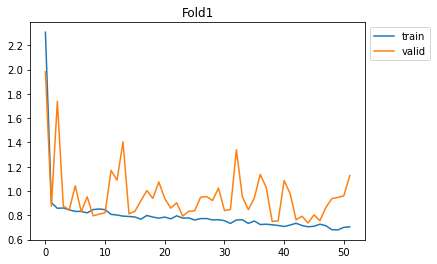

2021-07-21 08:04:48,254 - __main__ - DEBUG - Complete prediction for train fold (646.581 seconds passed)
2021-07-21 08:04:50,038 - __main__ - DEBUG - Complete prediction for val fold (648.365 seconds passed)
2021-07-21 08:08:27,030 - __main__ - DEBUG - Complete prediction for test fold (865.356 seconds passed)
2021-07-21 08:08:27,050 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp024/cv_fold1_training.csv (865.376 seconds passed)
2021-07-21 08:08:27,057 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp024/cv_fold1_validation.csv (865.384 seconds passed)
2021-07-21 08:08:27,076 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp024/cv_fold1_test.csv (865.403 seconds passed)
2021-07-21 08:08:27,220 - __main__ - DEBUG - Save model ../scripts/../experiments/exp024/cv_fold1_model.torch (865.547 seconds passed)
2021-07-21 08:08:27,324 - __main__ - DEBUG - Complete fold 1 (865.651 seconds passed)
2021-07-21 08:08:27,328 - __mai

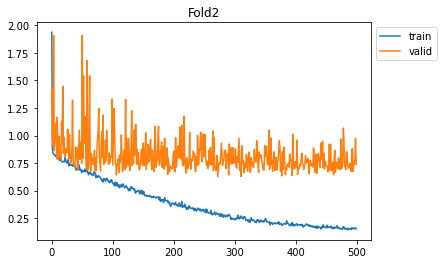

2021-07-21 09:18:33,497 - __main__ - DEBUG - Complete prediction for train fold (5071.824 seconds passed)
2021-07-21 09:18:35,194 - __main__ - DEBUG - Complete prediction for val fold (5073.520 seconds passed)
2021-07-21 09:18:45,063 - __main__ - DEBUG - Complete prediction for test fold (5083.389 seconds passed)
2021-07-21 09:18:45,081 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp024/cv_fold2_training.csv (5083.408 seconds passed)
2021-07-21 09:18:45,089 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp024/cv_fold2_validation.csv (5083.416 seconds passed)
2021-07-21 09:18:45,110 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp024/cv_fold2_test.csv (5083.437 seconds passed)
2021-07-21 09:18:45,249 - __main__ - DEBUG - Save model ../scripts/../experiments/exp024/cv_fold2_model.torch (5083.575 seconds passed)
2021-07-21 09:18:45,357 - __main__ - DEBUG - Complete fold 2 (5083.684 seconds passed)
2021-07-21 09:18:45,361

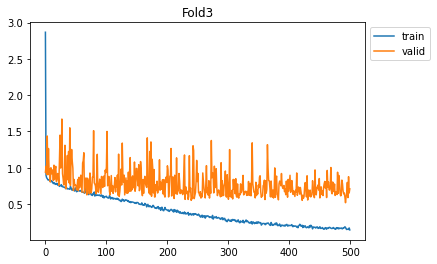

2021-07-21 10:29:44,602 - __main__ - DEBUG - Complete prediction for train fold (9342.929 seconds passed)
2021-07-21 10:29:46,376 - __main__ - DEBUG - Complete prediction for val fold (9344.703 seconds passed)
2021-07-21 10:29:56,319 - __main__ - DEBUG - Complete prediction for test fold (9354.645 seconds passed)
2021-07-21 10:29:56,336 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp024/cv_fold3_training.csv (9354.662 seconds passed)
2021-07-21 10:29:56,345 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp024/cv_fold3_validation.csv (9354.672 seconds passed)
2021-07-21 10:29:56,365 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp024/cv_fold3_test.csv (9354.692 seconds passed)
2021-07-21 10:29:56,492 - __main__ - DEBUG - Save model ../scripts/../experiments/exp024/cv_fold3_model.torch (9354.819 seconds passed)
2021-07-21 10:29:56,608 - __main__ - DEBUG - Complete fold 3 (9354.935 seconds passed)
2021-07-21 10:29:56,610

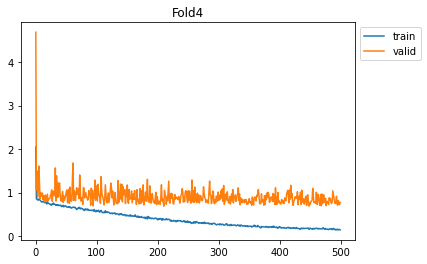

2021-07-21 11:41:12,029 - __main__ - DEBUG - Complete prediction for train fold (13630.355 seconds passed)
2021-07-21 11:41:13,890 - __main__ - DEBUG - Complete prediction for val fold (13632.217 seconds passed)
2021-07-21 11:41:24,455 - __main__ - DEBUG - Complete prediction for test fold (13642.782 seconds passed)
2021-07-21 11:41:24,476 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp024/cv_fold4_training.csv (13642.803 seconds passed)
2021-07-21 11:41:24,485 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp024/cv_fold4_validation.csv (13642.811 seconds passed)
2021-07-21 11:41:24,506 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp024/cv_fold4_test.csv (13642.833 seconds passed)
2021-07-21 11:41:24,643 - __main__ - DEBUG - Save model ../scripts/../experiments/exp024/cv_fold4_model.torch (13642.970 seconds passed)
2021-07-21 11:41:24,778 - __main__ - DEBUG - Complete fold 4 (13643.105 seconds passed)
2021-07-21 11:4

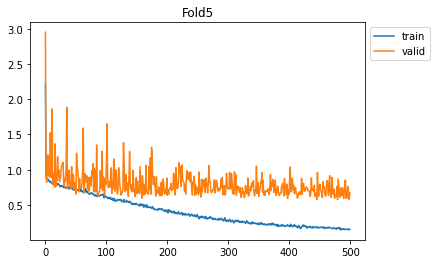

2021-07-21 12:53:24,168 - __main__ - DEBUG - Complete prediction for train fold (17962.495 seconds passed)
2021-07-21 12:53:26,162 - __main__ - DEBUG - Complete prediction for val fold (17964.489 seconds passed)
2021-07-21 12:53:37,044 - __main__ - DEBUG - Complete prediction for test fold (17975.371 seconds passed)
2021-07-21 12:53:37,063 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp024/cv_fold5_training.csv (17975.390 seconds passed)
2021-07-21 12:53:37,072 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp024/cv_fold5_validation.csv (17975.398 seconds passed)
2021-07-21 12:53:37,092 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp024/cv_fold5_test.csv (17975.418 seconds passed)
2021-07-21 12:53:37,238 - __main__ - DEBUG - Save model ../scripts/../experiments/exp024/cv_fold5_model.torch (17975.565 seconds passed)
2021-07-21 12:53:37,395 - __main__ - DEBUG - Complete fold 5 (17975.722 seconds passed)


In [21]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values

    torch.cuda.empty_cache()
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    model, input_size = initialize_model(MODEL_NAME)
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.MSELoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        predictions = {}
        for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                     [train_object_ids, valid_object_ids, test['object_id']]):
            # Prepare transformer
            transformer_ = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            # Prepare dataset
            dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
            # Prepare dataloader
            dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                     num_workers=os.cpu_count())
            # Prediction
            predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
            logger.debug('Complete prediction for {} fold ({:.3f} seconds passed)' \
                         .format(fold_, time.time() - SINCE))
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:  # Do not come here!
        raise NotImplemented
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [22]:
rmse = partial(mean_squared_error, squared=False)

In [23]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [24]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [25]:
metrics = defaultdict(list)

## Training set

In [26]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-21 12:53:37,446 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-21 12:53:37,472 - __main__ - DEBUG - Loss: 0.8190634615691145
2021-07-21 12:53:37,473 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-21 12:53:37,483 - __main__ - DEBUG - Loss: 0.3716194510505954
2021-07-21 12:53:37,484 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-21 12:53:37,492 - __main__ - DEBUG - Loss: 0.21929180954949867
2021-07-21 12:53:37,493 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-21 12:53:37,502 - __main__ - DEBUG - Loss: 0.5071559494539594
2021-07-21 12:53:37,503 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-21 12:53:37,511 - __main__ - DEBUG - Loss: 0.2796973765188902


In [27]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,0.97520,1
00309fb1ef05416f9c1f,2.04904,3
003a1562e97f79ba96dc,2.37839,3
004890880e8e7431147b,1.17671,2
00718c32602425f504c1,2.24799,3
...,...,...
ffa3259fff8e6f3818a1,2.10393,3
ffd4d361756587883e48,0.83318,1
ffd794b7b311b7b7fd92,1.59267,2


In [28]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-21 12:53:37,559 - __main__ - INFO - Training loss: 0.569292277823938


In [29]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-21 12:53:37,581 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp024/prediction_train.csv


## Validation set

In [30]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-21 12:53:37,606 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-21 12:53:37,614 - __main__ - DEBUG - Loss: 0.8584361909121758
2021-07-21 12:53:37,615 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-21 12:53:37,623 - __main__ - DEBUG - Loss: 0.7886364789222448
2021-07-21 12:53:37,624 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-21 12:53:37,631 - __main__ - DEBUG - Loss: 0.7170406703220842
2021-07-21 12:53:37,632 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-21 12:53:37,641 - __main__ - DEBUG - Loss: 0.828105454696136
2021-07-21 12:53:37,642 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-21 12:53:37,649 - __main__ - DEBUG - Loss: 0.7565298363033982


In [31]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.32170,1
00309fb1ef05416f9c1f,0.53615,3
003a1562e97f79ba96dc,0.60000,3
004890880e8e7431147b,0.25958,2
00718c32602425f504c1,0.34890,3
...,...,...
ffa3259fff8e6f3818a1,0.51145,3
ffd4d361756587883e48,0.33411,1
ffd794b7b311b7b7fd92,0.46969,2


In [32]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-21 12:53:37,688 - __main__ - INFO - Validatino loss: 1.6927667203119146


In [33]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-21 12:53:37,711 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp024/prediction_valid.csv


In [34]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-21 12:53:37,721 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp024/metrics.json


# Prediction

In [35]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [36]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.21174
000bd5e82eb22f199f44,2.36241
0015f44de1854f617516,1.83875
00388a678879ba1efa27,2.15009
005e1e7c6496902d23f3,0.50001
...,...
ffbe65ad399b632dcbd0,2.03518
ffd7b2d646c0320c311a,1.08518
ffdb93ede17d4501e530,1.83685


In [37]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.21174
1,2.36241
2,1.83875
3,2.15009
4,0.50001
...,...
5914,2.03518
5915,1.08518
5916,1.83685
5917,1.89848


In [38]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [39]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-21 12:53:37,843 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp024/024_submission.csv


2021-07-21 12:53:37,968 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp024/prediction.png


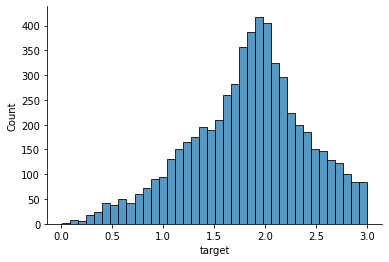

In [40]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [41]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 12:53:38,130 - __main__ - DEBUG - Complete (17976.457 seconds passed)
